- 到目前为止，我们只讨论了具有一个单向隐藏层的循环神经网络。其中，隐变量和观测值与具体的函数形式的交互方式是相当随意的。只要交互类型建模具有足够的灵活性，这就不是一个大问题。然而，对一个单层来说，这可能具有相当的挑战性。之前在线性模型中，我们通过添加更多的层来解决这个问题。而在循环神经网络中，我们首先需要确定如何添加更多的层，以及在哪里添加额外的非线性，因此这个问题有点棘手。
- 事实上，我们可以将多层循环神经网络堆叠在一起，通过对几个简单层的组合，产生了一个灵活的机制。特别是，数据可能与不同层的堆叠有关。例如，我们可能希望保持有关金融市场状况（熊市或牛市）的宏观数据可用，而微观数据只记录较短期的时间动态。
- 图9.3.1描述了一个具有L个隐藏层的深度循环神经网络，每个隐状态都连续地传递到当前层的下一个时间步和下一层的当前时间步。
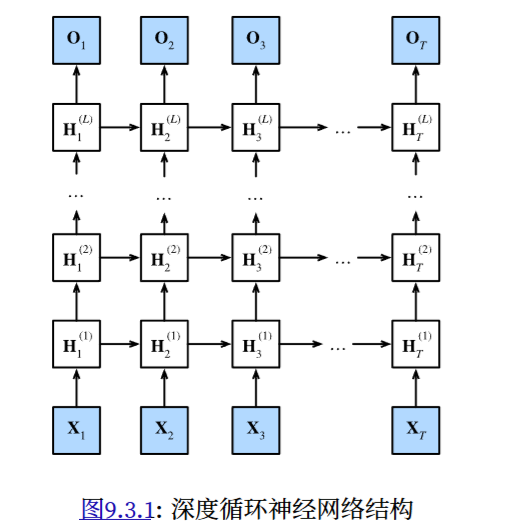

#### 模型结构
假设：
- 有 $L$ 层 RNN
- 输入序列为 $X = \{X_1, X_2, \dots, X_T\}$
- 每层隐藏状态为 $H^{(l)}_t$，表示第 $l$ 层在时间步 $t$ 的隐藏状态
---
#### 前向传播公式
对于每一个时间步 $t$ 和每一层 $l$，更新公式如下：
$$H^{(l)}_t = \tanh \left( W^{(l)}_{xh} H^{(l-1)}_t + W^{(l)}_{hh} H^{(l)}_{t-1} + b^{(l)}_h \right)$$
其中：
- $X^{(1)}_t = X_t$：第一层的输入是原始输入
#### 🧾 输出层计算
最终输出层的计算仅基于第l个隐藏层最终的隐状态：
$$Y_t = W_{hq} H^{(L)}_t + b_q$$

In [1]:
%matplotlib inline
import math
import torch
import random
import re
import collections
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#以下都是旧的代码搬过来直接用

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
'090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine(): #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def seq_data_iter_random(corpus,batch_size,num_steps):#@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，来自两个相邻随机小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y
#词元化
def tokenize(lines,token='word'):
    """将文本行拆分为单词或字符词元"""
    if token=='word':
        return [line.split() for line in lines]
    elif token=='char':
        return [list(line) for line in lines]
    else:
        print("错误:未知词元类型: "+token)
        
class Vocab:#@save
    """文本词表"""
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
                reserved_tokens=[]
        #按出现频率排序
        counter=count_corpus(tokens)
        self._token_freqs=sorted(counter.items(),key=lambda x:x[1],
                                     reverse=True)
        #未知词元的索引为0
        self.idx_to_token=['<unk>']+reserved_tokens
        self.token_to_idx={token:idx
                            for idx,token in enumerate(self.idx_to_token)}
        for token,freq in self._token_freqs:
            if freq<min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token]=len(self.idx_to_token)-1

    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token)for token in tokens]
    
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index]for index in indices]
    
    @property
    #@property是Python中的一个装饰器，把一个方法变成一个属性（像字段一样访问）
    def unk(self):#未知词元的索引为0
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):#@save
    """统计词元频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def load_corpus_time_machine(max_tokens=-1):#@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines=read_time_machine()
    tokens=tokenize(lines,'char')
    vocab=Vocab(tokens)
    #因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    #所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab =load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps, #@save
                            use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)
    def forward(self,inputs,state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                                batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

def grad_clipping(net,theta):   #@save
    """裁剪梯度"""
    if isinstance(net,nn.Module):
        params=[p for p in net.parameters() if p.requires_grad]
    else:
        params=net.params
    norm=torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm>theta:
        for param in params:
            param.grad[:]*=theta/norm

#@save
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    """训练网络一个迭代周期"""
    state,timer=None,d2l.Timer()
    metric=d2l.Accumulator(2)#训练损失之和，词元数量
    for X,Y in train_iter:
        if state is None or use_random_iter:
            #在第一次迭代或使用随机抽样时初始化state
            state=net.begin_state(batch_size=X.shape[0],device=device)
        else:
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                #state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y=Y.T.reshape(-1)
        X,y=X.to(device),y.to(device)
        y_hat,state=net(X,state)
        l=loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            #因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l*y.numel(),y.numel())
    return math.exp(metric[0]/metric[1]),metric[1]/timer.stop()

#预测
def predict_ch8(prefix,num_preds,net,vocab,device):#@save
    """在prefix后面生成新字符"""
    state=net.begin_state(batch_size=1,device=device)
    outputs=[vocab[prefix[0]]]
    get_input=lambda:torch.tensor([outputs[-1]],device=device).reshape((1,1))
    for y in prefix[1:]:    #预热期
        _,state=net(get_input(),state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  #预测num_preds步
        y,state=net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
#把一个字符列表合并成一个字符串，用 ''（空字符）作为连接符。

#训练函数的从零实现
#@save
def train_ch8(net,train_iter,vocab,lr,num_epochs,device,
              use_random_iter=False):
    """训练模型"""
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epoch',ylabel='perplexity',
                          legend=['train'],xlim=[10,num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


In [2]:
#深层RNN的简洁实现
batch_size,num_steps=32,35
train_iter,vocab=load_data_time_machine(batch_size,num_steps)

In [3]:
#像选择超参数这类架构决策也跟 9.2节中的决策非常相似。因为我们有不同的词元，所以输入和输出都选择相同数量，即vocab_size。隐藏单元的数量仍然是256。唯一的区别是，我们现在通过num_layers的值来设定隐藏层数。
vocab_size,num_hiddens,num_layers=len(vocab),256,2
num_inputs=vocab_size
device=d2l.try_gpu()
lstm_layer=nn.LSTM(num_inputs,num_hiddens,num_layers)
model=RNNModel(lstm_layer,len(vocab))
model=model.to(device)

困惑度 1.0, 146060.6 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
traveller with a slight accession ofcheerfulness really thi


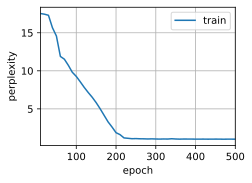

In [4]:
#训练与预测
#由于我们使用了LSTM模型来实例化两个层，因此训练速度被大大降低
num_epochs,lr=500,2
train_ch8(model,train_iter,vocab,lr*1.0,num_epochs,device)

小结
- 在深度循环神经网络中，隐状态的信息被传递到当前层的下一时间步和下一层的当前时间步。
- 有许多不同风格的深度循环神经网络，如长短期记忆网络、门控循环单元、或经典循环神经网络。这些模型在深度学习框架的高级API中都有涵盖。
- 总体而言，深度循环神经网络需要大量的调参（如学习率和修剪）来确保合适的收敛，模型的初始化也需要谨慎。